In [68]:
import json
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

from sklearn.metrics import average_precision_score, precision_recall_curve, auc, roc_curve

import sys
sys.path.append('..')
from lib import *
from numba import njit

plt.style.use('../peptidome.mplstyle')

Code for maxent model (not currently used)

def maxent_load(path):
    arr = np.load(path)
    hi = arr['hi']
    Jij = arr['Jij']
    @njit
    def energy(x): 
        return energy_potts(x, hi, Jij)
    loglikelihood = lambda seq: energy(map_aatonumber(seq))
    return loglikelihood
loglikelihood_human = maxent_load('../maxent/data/Human_9.npz')
loglikelihood_pathogen = maxent_load('../maxent/data/Malaria_9.npz')

In [ ]:
# excess factor of self peptides
negative_excess = 10

In [ ]:
all_data = {}
for i, pathogen in enumerate(['CMV', 'Malaria']):
    arr = np.load('data/%s.npz'%pathogen)
    data = {}
    
    logp_hh, logp_pp, logp_hp, logp_ph = arr['logp_hh'], arr['logp_pp'], arr['logp_hp'], arr['logp_ph']
    data['logp_hh'], data['logp_pp'], data['logp_hp'], data['logp_ph'] = logp_hh, logp_pp, logp_hp, logp_ph
    
    positive = (logp_ph-logp_pp)
    negative = (logp_hh-logp_hp)[np.random.randint(len(logp_hh), size=len(positive)*negative_excess)]
    y_true = np.concatenate([np.ones(len(positive)), np.zeros(len(negative))])
    y_score = -np.concatenate([positive, negative])
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    data['fpr'], data['tpr'], data['roc_auc'] = fpr, tpr, roc_auc
    
    #N = int(1e5)
    #negative = (logp_hh-logp_hp)[np.random.randint(len(logp_hh), size=10*N)]
    #positive = (logp_ph-logp_pp)[np.random.randint(len(logp_ph), size=N)]
    #y_true = np.concatenate([np.ones(len(positive)), np.zeros(len(negative))])
    #y_score = -np.concatenate([positive, negative])
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)

    data['precision'], data['recall'], data['average_precision'] = precision, recall, average_precision

    all_data[pathogen] = data

In [ ]:
fig, axes = plt.subplots(figsize=(5.5, 3.75), ncols=3, nrows=2)

for i, pathogen in enumerate(['CMV', 'Malaria']):
    
    data = all_data[pathogen]
    logp_hh, logp_pp, logp_hp, logp_ph = data['logp_hh'], data['logp_pp'], data['logp_hp'], data['logp_ph']
    
    ax = axes[i, 0]
    plot_histograms([logp_hp-logp_hh, logp_pp-logp_ph], ['Human', pathogen], xmin=-5, xmax=5, ax=ax, nbins=100)
    ax.set_xlabel(r'loglikelihood ratio $\log \left( \frac{\mathcal{L}_P(s)}{\mathcal{L}_H(s)} \right)$')
    ax.set_yticks([])
    ax.set_ylabel('Frequency')
    ax.set_xlim(-5, 5)
    ax.set_ylim(0.0)
    ax.legend(loc='upper right')

    ax = axes[i, 1]
    ax.plot(data['fpr'], data['tpr'], label='AUROC = %0.2f' % data['roc_auc'])
    ax.plot([0, 1], [0, 1], color='k', linestyle='--', label='random')
    ax.set_xlim(0.0, 1.01)
    ax.set_ylim(0.0, 1.01)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
    ax = axes[i, 2]
    #ax.plot(recall, 1-precision)
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #ax.set_ylim(1e-5)
    #ax.set_xlim(1e-5)
    #ax.set_ylabel('1-precision')
    ax.plot(data['recall'], data['precision'], label='AP = {0:0.2f}'.format(data['average_precision']))
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    ax.axhline(1.0/negative_excess, c='k', ls='--', label='random')
    ax.set_ylim(0.0, 1.01)
    ax.set_xlim(0.0, 1.01)
    ax.legend(loc='upper right')

label_axes(axes[:, 0].flatten(), xy=(-0.1, 1.0), labels='AD')
label_axes(axes[:, 1:].flatten(), xy=(-0.25, 1.0), labels='BCEF')
fig.tight_layout()
fig.savefig('main.png')
fig.savefig(figuredir + 'classifier.svg')

In [ ]:
fig, ax = plt.subplots()
plot_histograms([logp_hh, logp_pp, logp_hp, logp_ph],
                ['h|h', 'p|p', 'h|p', 'p|h'],
                nbins=100,
                xmin=-15, xmax=-7, ax=ax)
ax.set_yticks([])
ax.set_ylim(0.0)
ax.set_ylabel('relative frequency')
ax.set_xlabel('$\log_{10}$ probability for given proteome statistics')
fig.tight_layout()

In [3]:
ks = np.arange(1, 11)
counters_human = [count_kmers_proteome(human, k, clean=True) for k in ks]

In [5]:
n = sum(counters_human[0].values())
p0 = 1/20**ks

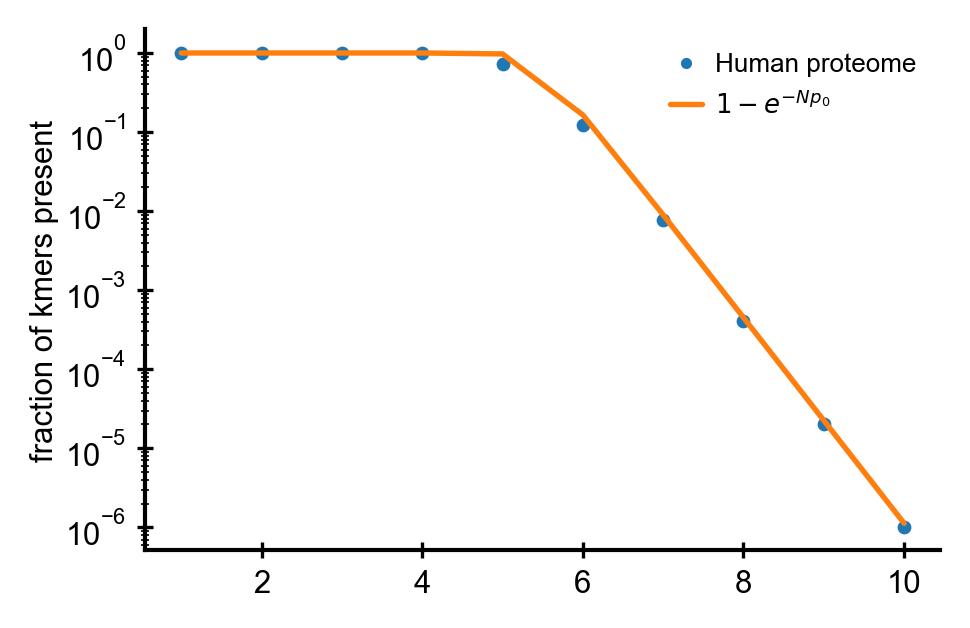

In [6]:
fig, ax = plt.subplots()
ax.plot(ks, np.array([len(c) for c in counters_human])/20**ks, 'o', label='Human proteome')
ax.plot(ks, 1-np.exp(-n*p0), label='$1-e^{-N p_0}$')
ax.set_yscale('log')
ax.set_ylabel('fraction of kmers present')
ax.legend(loc='upper right')

In [7]:
counters_human[8]

{'MGAPLLSPG': 2,
 'GAPLLSPGW': 2,
 'APLLSPGWG': 2,
 'PLLSPGWGA': 2,
 'LLSPGWGAG': 2,
 'LSPGWGAGA': 2,
 'SPGWGAGAA': 2,
 'PGWGAGAAG': 2,
 'GWGAGAAGR': 2,
 'WGAGAAGRR': 2,
 'GAGAAGRRW': 2,
 'AGAAGRRWW': 2,
 'GAAGRRWWM': 2,
 'AAGRRWWML': 2,
 'AGRRWWMLL': 2,
 'GRRWWMLLA': 2,
 'RRWWMLLAP': 2,
 'RWWMLLAPL': 2,
 'WWMLLAPLL': 2,
 'WMLLAPLLP': 2,
 'MLLAPLLPA': 2,
 'LLAPLLPAL': 2,
 'LAPLLPALL': 2,
 'APLLPALLL': 2,
 'PLLPALLLV': 2,
 'LLPALLLVR': 2,
 'LPALLLVRP': 2,
 'PALLLVRPA': 2,
 'ALLLVRPAG': 2,
 'LLLVRPAGA': 2,
 'LLVRPAGAL': 2,
 'LVRPAGALV': 2,
 'VRPAGALVE': 2,
 'RPAGALVEG': 2,
 'PAGALVEGL': 2,
 'AGALVEGLY': 2,
 'GALVEGLYC': 2,
 'ALVEGLYCG': 2,
 'LVEGLYCGT': 2,
 'VEGLYCGTR': 2,
 'EGLYCGTRD': 2,
 'GLYCGTRDC': 2,
 'LYCGTRDCY': 2,
 'YCGTRDCYE': 2,
 'CGTRDCYEV': 2,
 'GTRDCYEVL': 2,
 'TRDCYEVLG': 2,
 'RDCYEVLGV': 2,
 'DCYEVLGVS': 2,
 'CYEVLGVSR': 2,
 'YEVLGVSRS': 2,
 'EVLGVSRSA': 2,
 'VLGVSRSAG': 2,
 'LGVSRSAGK': 2,
 'GVSRSAGKA': 2,
 'VSRSAGKAE': 2,
 'SRSAGKAEI': 2,
 'RSAGKAEIA': 2,
 'SAGKAEIAR': 

In [14]:
set(counters_malaria[8])

{'GDINGGGDI',
 'HEQNINSCE',
 'LVLKRIGNR',
 'NSIGPGIAY',
 'GIHTIYFLL',
 'QIVKQEWPD',
 'HSIVIYKYK',
 'KIKVKIGNN',
 'LYIDKLDNL',
 'NNNNDHHHN',
 'ELAEQIRQE',
 'ENKNNDKNI',
 'TSLHREDIL',
 'DVIEKENDQ',
 'VFKVYNPDN',
 'INNLNTNDL',
 'NNNNNIINM',
 'TNKKGDDYL',
 'HFVNLPIHI',
 'LPSEEEIYS',
 'IYYNKKKFK',
 'YSSIDAYKH',
 'CNYRVKNVK',
 'NLKNMSDYR',
 'LTEYQKYQK',
 'YCFFLLTEK',
 'LQNLDDVDM',
 'NNNPIYNWK',
 'IDVPYLNTE',
 'QRIEYSAVI',
 'TYNTEGKRN',
 'LHDNLNNSL',
 'VRSYNLFTS',
 'NIIVLLSPQ',
 'LPLPFVDFP',
 'KISNSFNMK',
 'RLGFNENDS',
 'SYKCDAENN',
 'NESILHYDL',
 'PIKRTKKKN',
 'IVDEHFDFK',
 'KNLVDCKYC',
 'EEVVEKMVL',
 'NFKKQVIKN',
 'PPTHIPSST',
 'RIIVDQMKK',
 'ICNYLTYDK',
 'KDIQKKEYE',
 'NYQLYPYNL',
 'DQKKEAHEK',
 'SSYNINVRE',
 'SNEISNKSD',
 'NPFYNIHHS',
 'NYDDNKNDD',
 'NTLFLLPFC',
 'EHNNTKLIR',
 'LLMELSKKD',
 'EFINIQNMK',
 'DIISHIKLN',
 'LVLAKYNDN',
 'NDVLKKKEK',
 'NCLPPDYYN',
 'NTTKYNFFE',
 'IDKSQNYNY',
 'HYNKSFMLK',
 'LKRKQSQIT',
 'KQCYRCCCF',
 'SNFIGCLDY',
 'PYVGDDKKA',
 'YKPNDLNKI',
 'EQQTKESIQ',
 'SSNV

In [17]:
k = 9
counter_cmv = count_kmers_proteome(proteome_path('CMV'), k, clean=True)
counter_malaria = count_kmers_proteome(proteome_path('Malaria'), k, clean=True) 

In [18]:
set_cmv = set(counter_cmv)
set_human = set(counters_human[8])
set_malaria = set(counter_malaria)

In [23]:
len(set_cmv), len(set_cmv.intersection(set_human))

(63038, 124)

In [27]:
len(set_malaria), len(set_malaria.intersection(set_human))

(3811082, 12175)

In [62]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    print(m)
    if m == str(1):
        print(m)
        return r'10^{{{e:d}}}'.format(e=int(e))
    return r'{m:s}\cdot 10^{{{e:d}}}'.format(m=m, e=int(e))

4
1
1
1
1


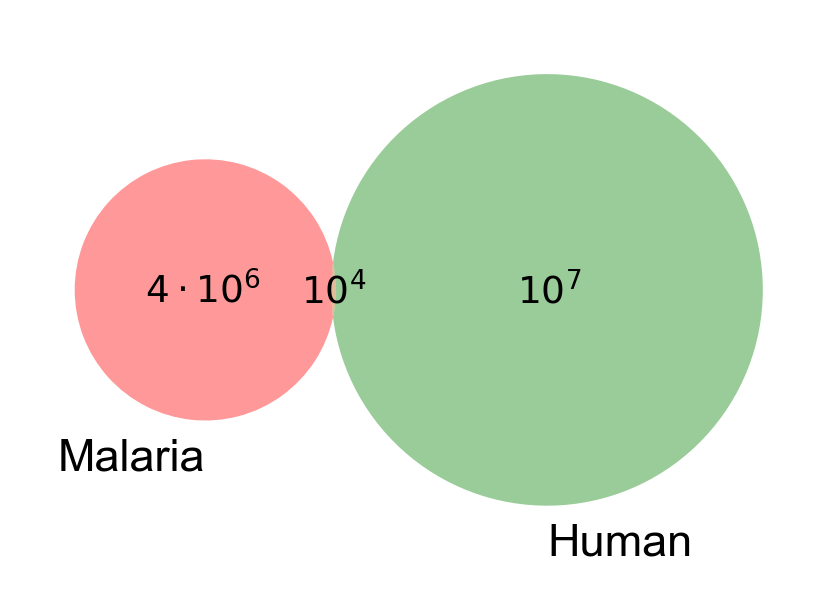

In [70]:
venn2([set_malaria, set_human], set_labels=['Malaria', 'Human'],
      subset_label_formatter=lambda s: '${:s}$'.format(as_si(s, ndp=0)))